In [1]:
from collections import defaultdict
import numpy as np # для работы с числами, массивами
import scipy.stats as stats
import matplotlib.pyplot as plt # основная библиотека для графиков
from pandas import Series, DataFrame # базовая библиотека для работы с данными
from pandas.tools.plotting import scatter_matrix # рисует много диаграмм рассеяния за раз, удобнее цикла
import pandas as pd
from statsmodels.formula.api import ols # линейная регрессия с r-style формулами (метод наименьших квадратов)
from statsmodels.graphics.api import interaction_plot, abline_plot
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels import graphics
%matplotlib inline

In [4]:
all_data_table = pd.read_table('data/langs_all_info_merged.tsv', index_col=0)

# копия, чтоб иметь исходные данные на всякий случай под рукой
data_table_copy = all_data_table.copy()

Отберём отдельно категориальные признаки, чтоб не путать их с другими числовыми признаками. Для корректного построения линейной регрессии каждый категориальный признак нужно превращать в набор векторов из 0-1 - это делается из-за того, что мы не знаем, чем один регион как категориальный признак лучше другого, а значит не можем адекватно численно выразить это различие. Допустим, мы считаем, что Википедия на малом языке лучше Вики-инкубатора и гораздо лучше отсутствия даже инкубатора и поэтому должна иметь значение больше, но мы не можем знать наверняка порядок этих соотношений (0-1-2 или 0-2-4 или 0-3-6).

In [5]:
# категориальные признаки
categorical_cols = ['lang_wiki', 'lang_family', 'lang_region', 'lang_religion', 'lang_status', 'region_FedDistrict']

# надо ремапить в 0-1 (т.е. этот признак тоже категориальный скорее, но его легко переделать только в True-False, 0-1)
to_remap = ['iso_code']

# лишнее в нашей таблице (дубли и признаки, корреляции с которыми не интересны)
to_del = ['lang', 'lang_code', 'trash_tokens', 'lang_write_system', 'lang_write_system_comment']

# отсутствующие данные можно заполнить нулями
na_to_zero = ['lang_wiki_03_2014', 'lang_wiki_articles_2015', 'lang_wiki_articles_2016', 'lang_wiki_admins_2016',
              'lang_wiki_active_users_2016']

Убираем лишнее, заполняем пустые строки Википедии нулями.

In [6]:
# NB! можно запустить это только 1 раз, дальше будет падать с ошибкой, т.к. операция производится inplace
data_table_copy.drop(to_del, axis=1, inplace=True)
for col in na_to_zero:
    data_table_copy[col].fillna(0, inplace=True)

Отберём пока только цифровые данные и составим два набора данных:
1. для регрессии составим набор, в котором нет данных по вконтакту, зато есть все остальные
2. для кластеризации и регрессии по всем онлайн-данным уберём строки с неполными данными по интернет-коллекции и вк-коллекции.

In [7]:
only_numeric_data = data_table_copy.select_dtypes(include=[np.number])

# True - False, где нет данных про интернет
no_inet_data = only_numeric_data['all_domains'] >= 0 
# True - False, где нет данных про ВК
no_vk_data = only_numeric_data['vk_communities'] >= 0

# numeric data with data from text collections only
numeric_data_corp = only_numeric_data[no_inet_data & no_vk_data]

# numeric data with inet data and no vk data
vk_cols = ['vk_communities', 'vk_posts', 'vk_posts_in_lang', 'lang_tokens_vk']
numeric_data_inet = only_numeric_data[no_inet_data]
numeric_data_inet = numeric_data_inet.drop(vk_cols, axis=1)

Чтобы данные по iso-code не попали в основную таблицу числовых данных, сделаем ремаппинг в 0-1 здесь.

In [8]:
data_table_copy[to_remap] = data_table_copy[to_remap].apply(lambda x: 1 if(np.any(pd.notnull(x))) else 0, axis = 1)

# Немного описания исходных данных #

Описательные статистики про каждый столбец наших числовых данных

    count - кол-во не NA данных
    mean - среднее арифиметическое на столбец
    std - выборочное стандартное отклонение (Normalized by N-1)
    min - минимальное значение в столбце
    25% - персентили
    50% -
    75% -
    max - максимальное значение в столбце

In [9]:
numeric_data_inet.describe().round(decimals=2)

,all_domains,lang_tokens,rus_tokens,token_median,type1_domains_crawled,type1_domains_found,type1_to_all,urls,lang_number_2010,lang_wiki_03_2014,...,region_number_computers_per_family2010,region_population_growth2014,region_rating_indx2013,region_rating_indx2014,region_rating_position2013,region_rating_position2014,region_sr_dush_doxod2002,region_sr_dush_doxod2010,region_sr_mes_zp_2010,region_sr_mes_zp_2015
count,44.00,4.400000e+01,4.400000e+01,44.00,44.00,44.00,44.00,44.00,44.00,44.00,...,40.00,44.00,44.00,44.00,44.00,44.00,43.00,44.00,44.00,44.00
mean,158.41,9.751652e+06,2.213949e+07,219.08,2.50,3.52,0.01,30336.57,172246.25,1740.36,...,0.54,6.88,34.81,35.95,57.39,58.61,3644.58,17762.00,18576.08,9845.98
std,225.96,3.130299e+07,7.371986e+07,221.69,4.80,6.82,0.02,95724.73,294712.15,5425.58,...,0.23,6.49,9.92,8.40,23.22,20.80,3087.78,8108.83,11858.29,17960.00
min,1.00,1.090000e+02,4.000000e+00,5.00,0.00,0.00,0.00,1.00,7.00,0.00,...,0.00,-4.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,5.00,2.287700e+04,2.106375e+04,60.00,0.00,0.00,0.00,27.00,2205.75,0.00,...,0.38,0.94,33.33,33.75,46.75,48.00,1534.00,13199.78,10186.60,15.70
50%,54.00,3.419465e+05,7.027140e+05,135.50,1.00,1.00,0.00,415.00,39915.50,0.00,...,0.54,6.46,33.66,34.12,69.50,70.00,2145.50,15678.30,12858.30,20.10
75%,161.25,1.979954e+06,3.026777e+06,293.50,2.25,3.00,0.02,8203.00,261004.75,1186.00,...,0.75,13.54,40.46,41.11,73.00,71.00,4995.73,22314.95,23078.80,16700.00
max,773.00,1.730682e+08,3.725382e+08,847.00,19.00,29.00,0.07,534593.00,1354705.00,28247.00,...,1.13,19.03,51.37,51.33,82.00,83.00,13298.10,43367.10,52720.90,64200.00


У Сары Бослаф написано, что для линейной регрессии и большинства других статистических тестов данные надо проверять на нормальность. Это можно делать двумя способами: по гистограмме "на глаз" или с помощью статистического теста Колмогорова-Смирнова.

Значения теста, видимо, надо интерпретировать так, что если p-value равно 0.0, то тест с треском проваливается. У нас такое для большинства значений. Вообще говоря, реальные данные редко удовлетворяют тестам на нормальность, поэтому прибегнем в первому способу - построению гистограмм. К тому же на практике этот способ используют гораздо чаще.

# Обработка данных #

Построим гистограммы и диаграммы рассеяния для наших признаков, чтоб проверить, нужны ли какие-то преобразования для данных перед проведением статистического анализа.

### Гистограммы

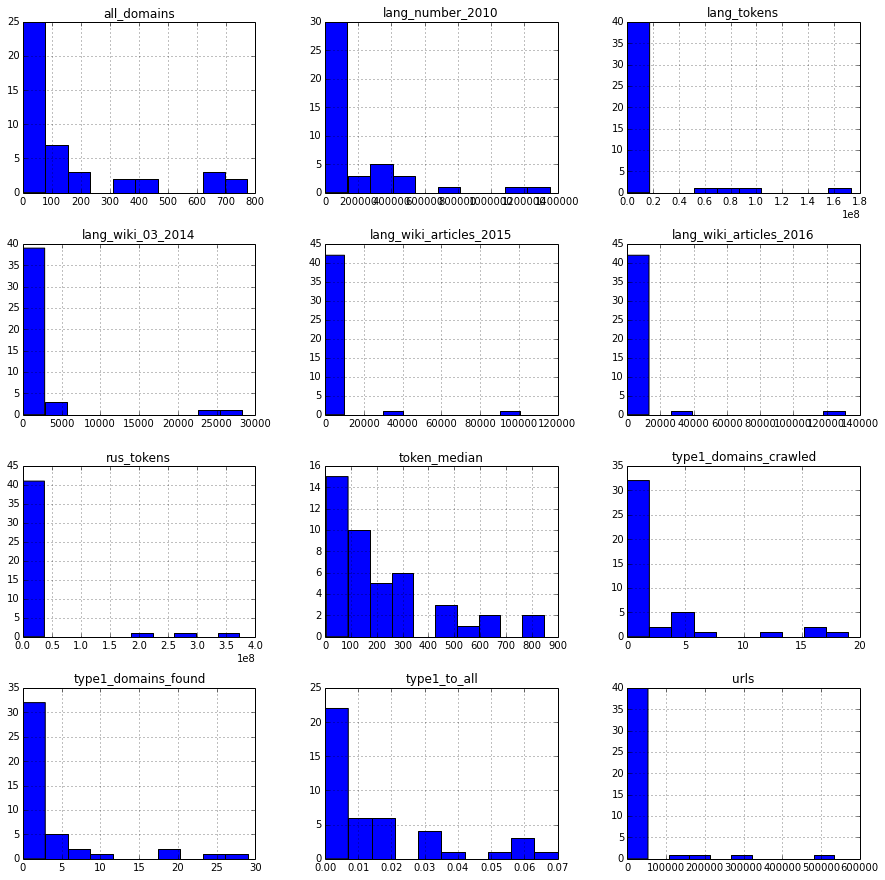

In [14]:
# данных очень много, поэтому гистограммы разумнее рисовать частями
numeric_data_inet.ix[:, :12].hist(figsize=(15, 15))
plt.show()

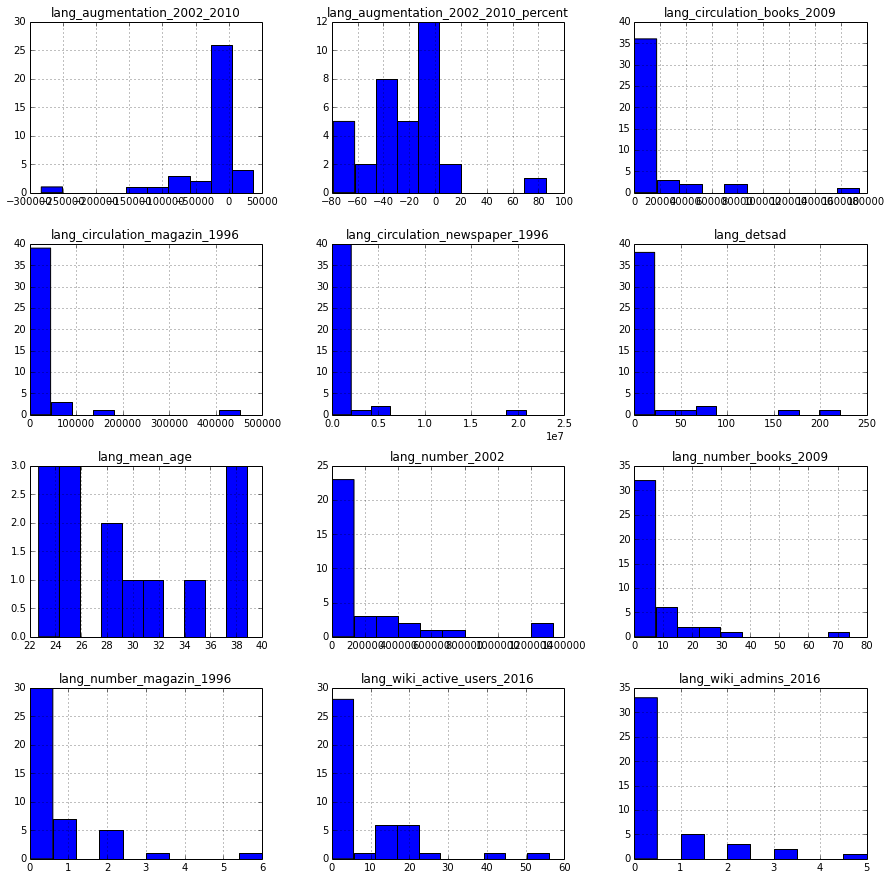

In [15]:
numeric_data_inet.ix[:, 12:24].hist(figsize=(15, 15))
plt.show()

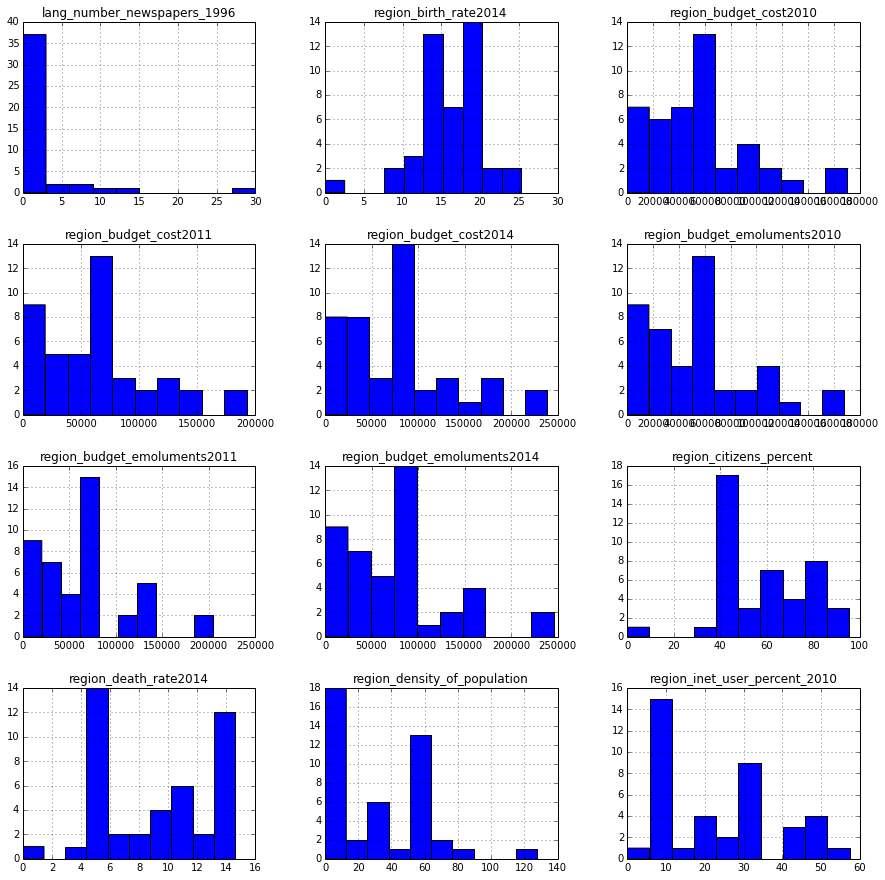

In [16]:
numeric_data_inet.ix[:, 24:36].hist(figsize=(15, 15))
plt.show()

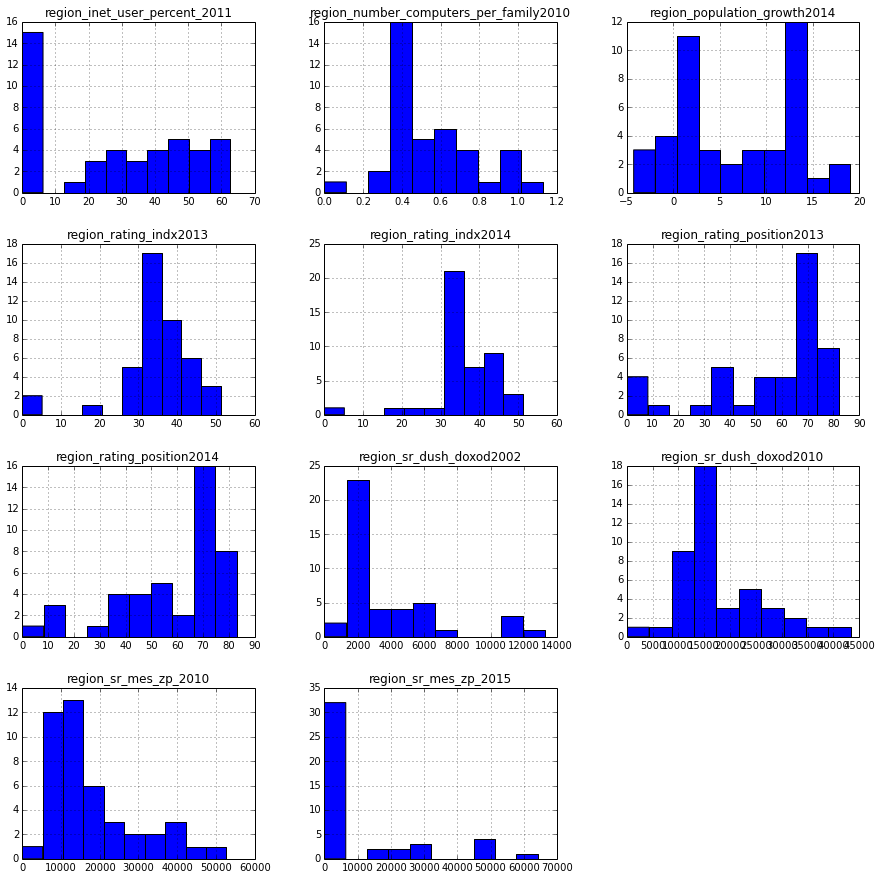

In [13]:
numeric_data_inet.ix[:, 36:52].hist(figsize=(15, 15))
plt.show()

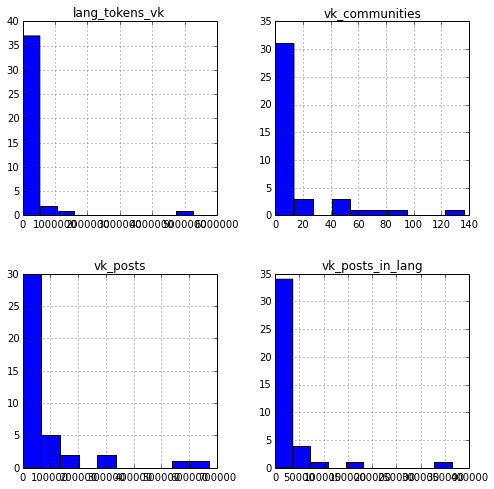

In [17]:
# отдельно vk-данные из первой таблицы
numeric_data_corp[vk_cols].hist(figsize=(8, 8))
plt.show()

Уже по гистограммам видно, что большинство признаков далеки от нормального распределения, а также что в статьях, постах, сообществах, урлах и доменах есть по паре аутлаеров (это скорее всего немногочисленные языки с большей представленностью в интернете, например, такие как чувашский и бурятский).

Продолжим с диаграммами рассеяния.

### Диаграммы рассеяния с гауссианой

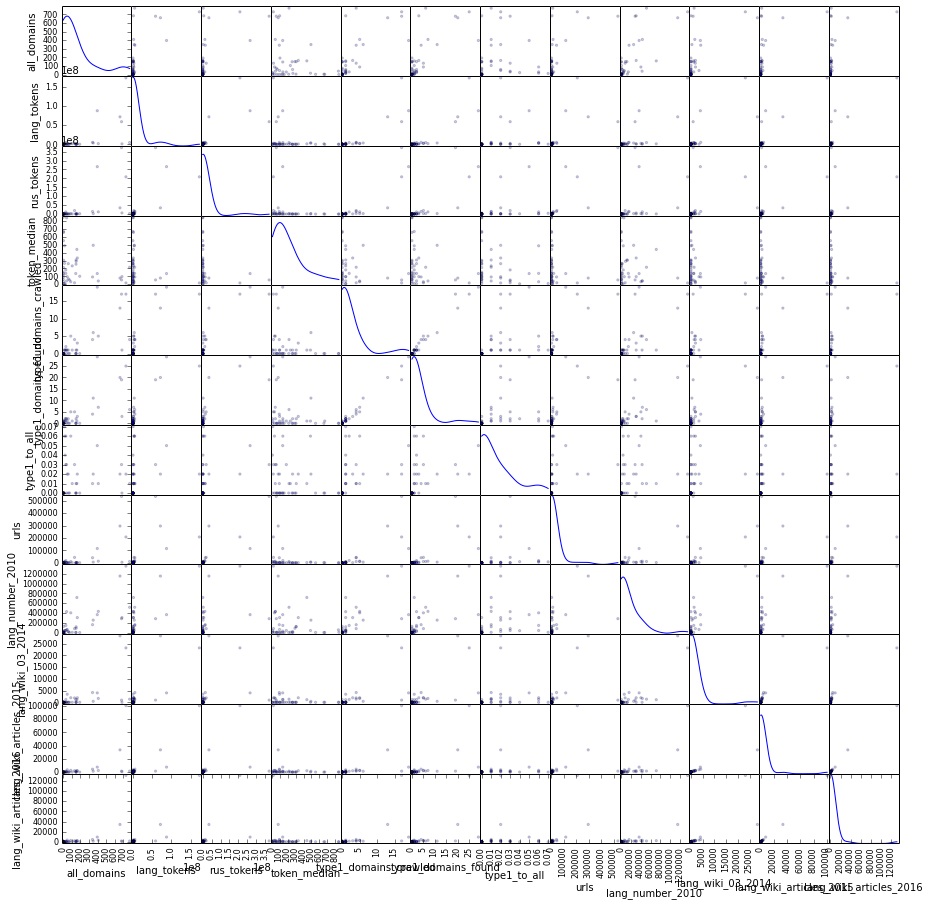

In [19]:
scatter_matrix(numeric_data_inet.ix[:, :12], alpha=0.2, figsize=(15, 15), diagonal='kde')
plt.show()

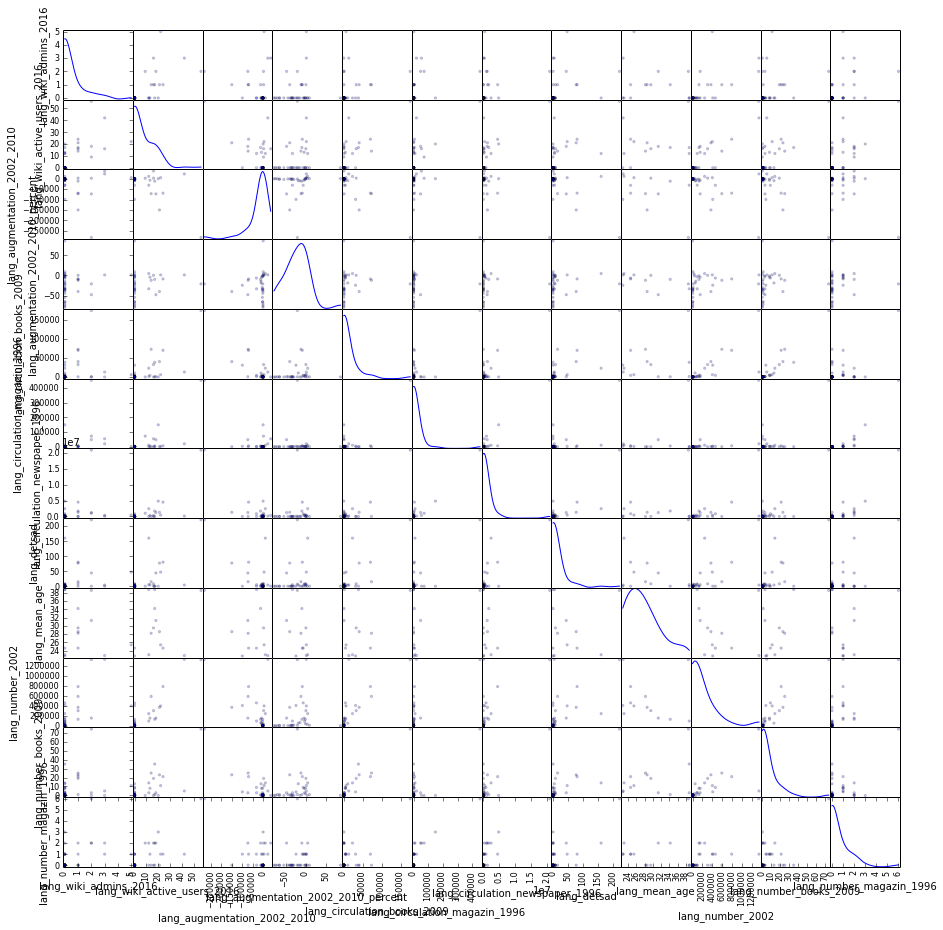

In [20]:
scatter_matrix(numeric_data_inet.ix[:, 12:24], alpha=0.2, figsize=(15, 15), diagonal='kde')
plt.show()

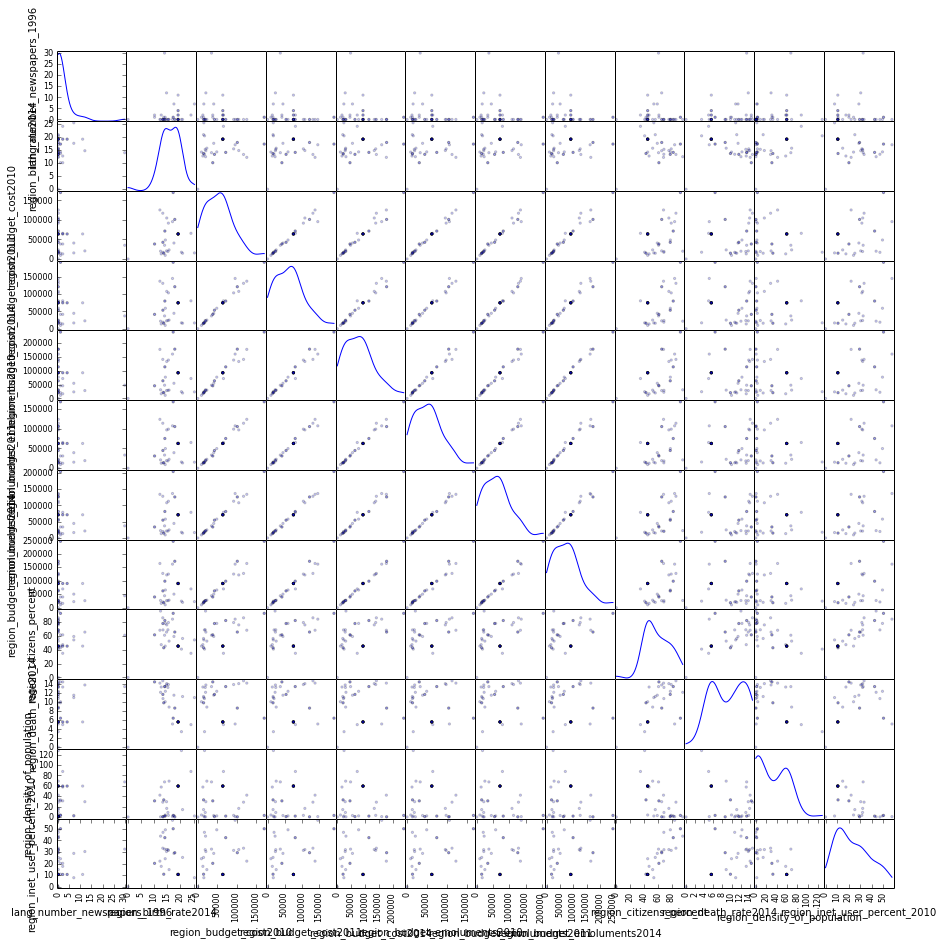

In [21]:
scatter_matrix(numeric_data_inet.ix[:, 24:36], alpha=0.2, figsize=(15, 15), diagonal='kde')
plt.show()

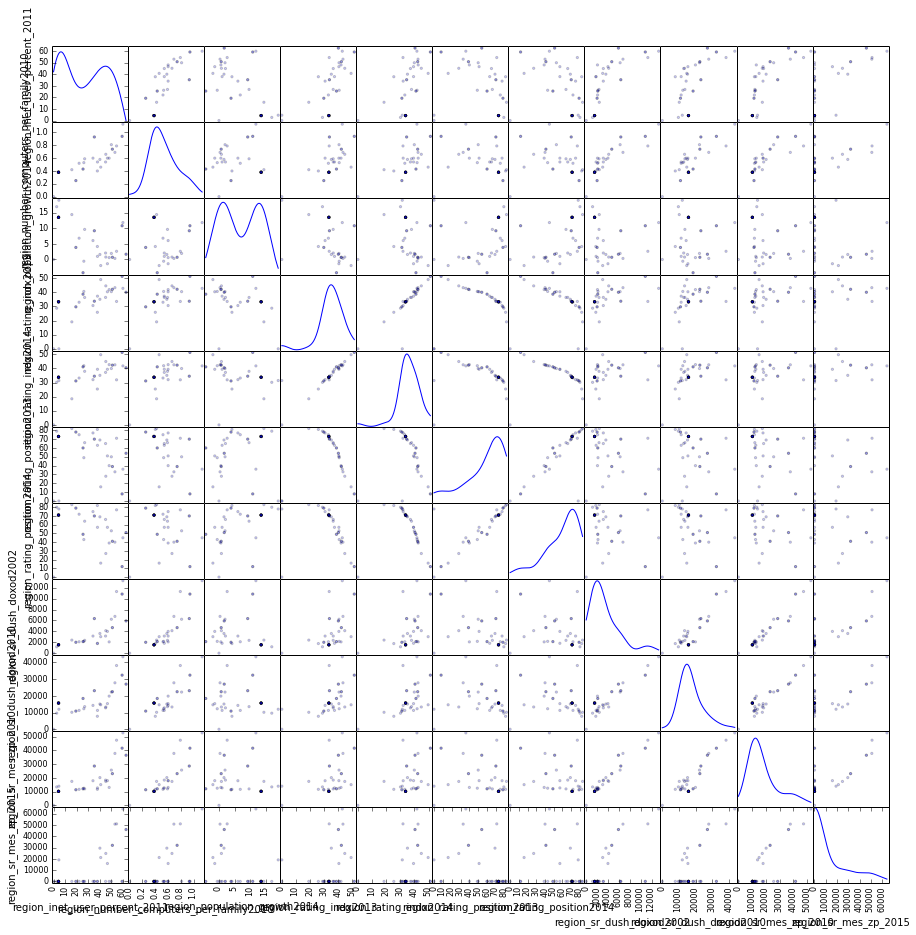

In [22]:
scatter_matrix(numeric_data_inet.ix[:, 36:52], alpha=0.2, figsize=(15, 15), diagonal='kde')
plt.show()

Теперь мы убедились, что для большинства данных хорошо бы взять натуральный логарифм.

In [23]:
# нелогарифмировала те, что более менее похожи на купол и те, где есть отрицательные значения
cols_to_ln = ['all_domains', 'lang_tokens', 'rus_tokens', 'token_median',
            'type1_domains_crawled', 'type1_domains_found', 'type1_to_all', 'urls',
            'lang_number_2010', 'lang_number_2002',
            'lang_wiki_03_2014', 'lang_wiki_articles_2015',
            'lang_wiki_articles_2016', 'lang_wiki_admins_2016',
            'lang_wiki_active_users_2016',
            'lang_augmentation_2002_2010', 'lang_detsad', 'lang_mean_age',
            'lang_circulation_books_2009', 'lang_number_books_2009',
            'lang_circulation_magazin_1996', 'lang_number_magazin_1996',
            'lang_circulation_newspaper_1996', 'lang_number_newspapers_1996',
            'region_death_rate2014', 'region_density_of_population',
            'region_inet_user_percent_2010', 'region_inet_user_percent_2011', 
            'region_sr_mes_zp_2015']

inet_ln_cols = [str(x) + "_ln" for x in cols_to_ln]

# натуральный логарифм со смягчением, чтоб не терять нули
inet_num_data_ln = numeric_data_inet[cols_to_ln].apply(lambda x: np.log(x + 1))
inet_num_data_ln.columns = inet_ln_cols

# составляем таблицу с логарифмами
numeric_inet_data_after_ln = inet_num_data_ln

# дополняем её теми данными, которые решили не логарифмировать
inet_not_ln_cols = [col for col in list(numeric_data_inet.columns[:52]) if col not in list(cols_to_ln)]

numeric_inet_data_after_ln = numeric_inet_data_after_ln.join(numeric_data_inet[inet_not_ln_cols])

# и тоже самое для данных, где есть vk
cols_to_ln.extend(vk_cols)
ln_cols = [str(x) + "_ln" for x in cols_to_ln]

num_data_ln = numeric_data_corp[cols_to_ln].apply(lambda x: np.log(x + 1))
num_data_ln.columns = ln_cols

numeric_data_after_ln = num_data_ln

not_ln_cols = [col for col in list(numeric_data_corp.columns[:52]) if col not in list(cols_to_ln)]

numeric_data_after_ln = numeric_data_after_ln.join(numeric_data_corp[not_ln_cols])

In [24]:
# А теперь отнормируем все наши данные
inet_mean = numeric_inet_data_after_ln.mean()
inet_std = numeric_inet_data_after_ln.std()
numeric_inet_data_norm = (numeric_inet_data_after_ln - inet_mean) / (inet_std)

# в столбцах, где было много nan изначально, нормировка даёт полный столбец nan, выкинем их
numeric_inet_data_norm = numeric_inet_data_norm.dropna(axis=1, how='all')

# и тоже самое для данных, где есть vk
mean = numeric_data_after_ln.mean()
# std = numeric_data_after_ln.max() - numeric_data_after_ln.min()
std = numeric_data_after_ln.std()
numeric_data_norm = (numeric_data_after_ln - mean) / (std)

numeric_data_norm = numeric_data_norm.dropna(axis=1, how='all')

Проверим, как теперь выглядят наши данные.

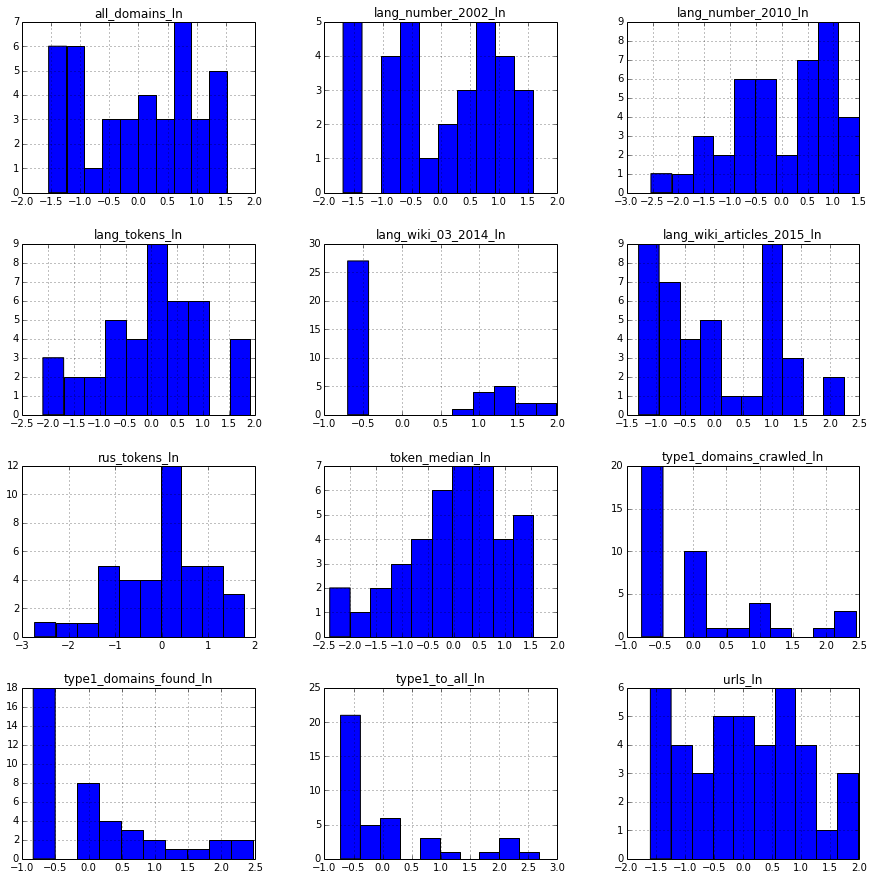

In [26]:
numeric_data_norm.ix[:, :12].hist(figsize=(15, 15))
plt.show()

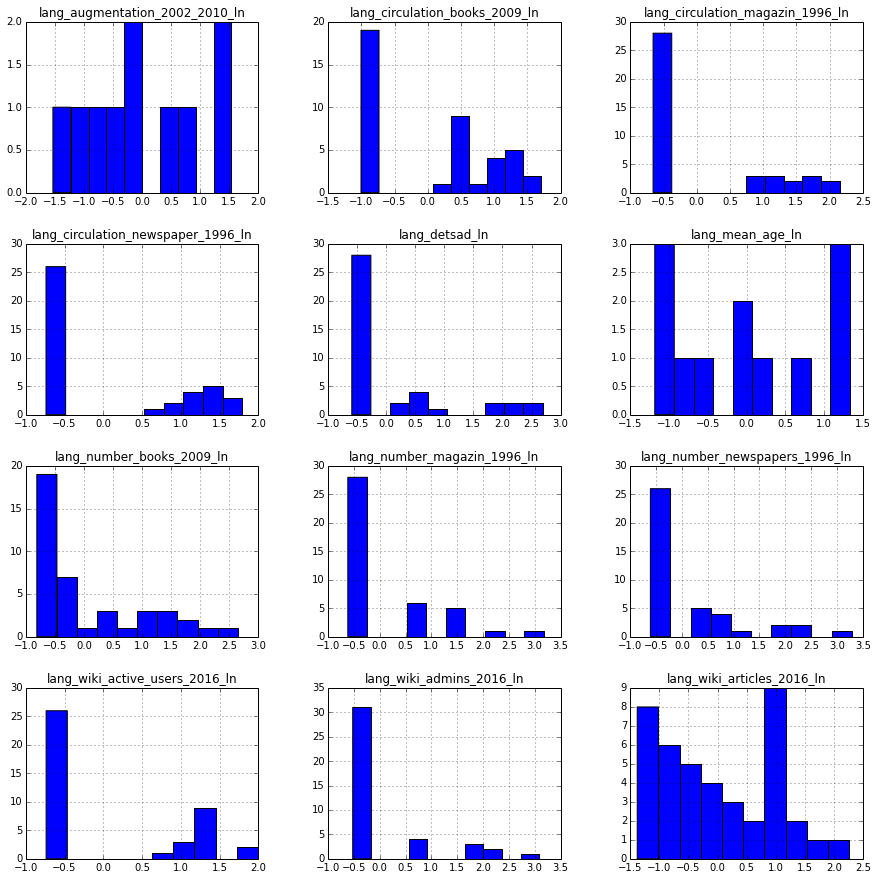

In [27]:
numeric_data_norm.ix[:, 12:24].hist(figsize=(15, 15))
plt.show()

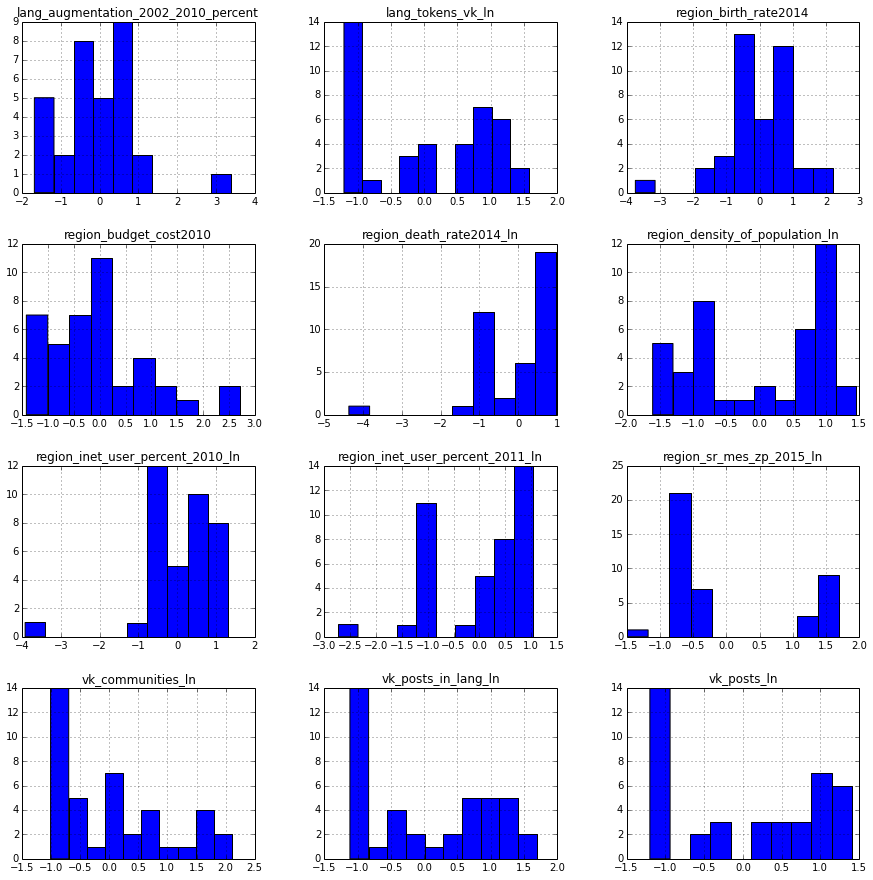

In [28]:
numeric_data_norm.ix[:, 24:36].hist(figsize=(15, 15))
plt.show()

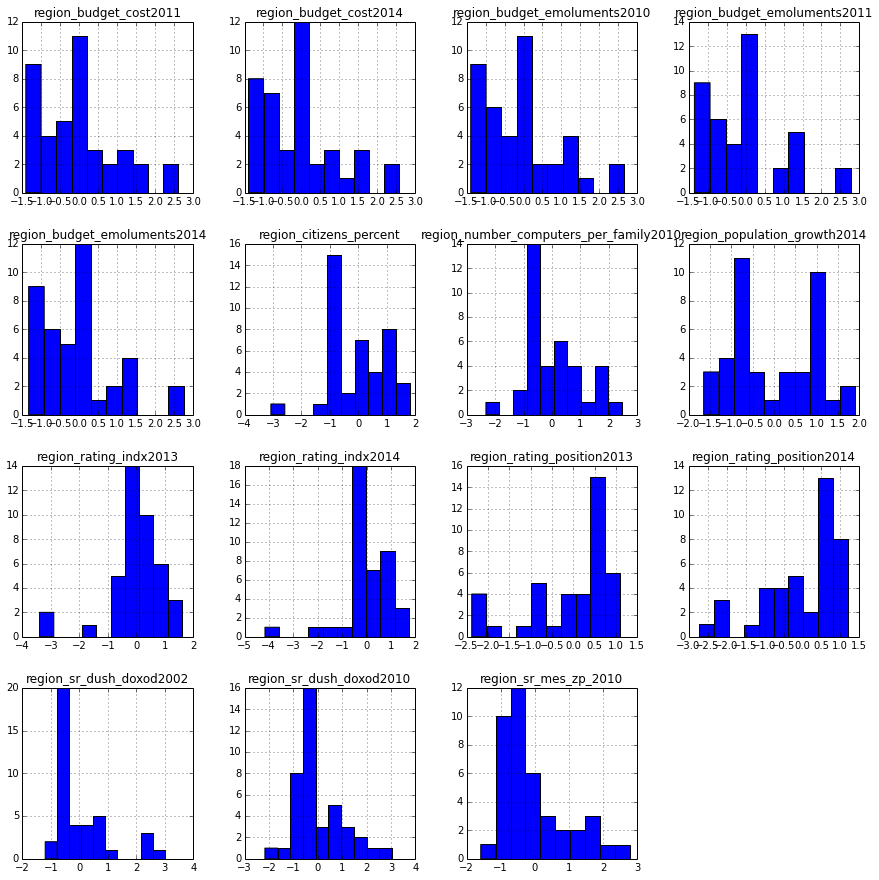

In [29]:
# данные, от которых я не брала логарифм
numeric_data_norm.ix[:, 36:51].hist(figsize=(15, 15))
plt.show()

По гистограммам видно, что распределение для большинства признаков стало гораздо ближе к нормальному.

In [30]:
# with open('langs_all_info_normed.tsv', 'w', encoding='utf-8') as fd:
#     numeric_data_norm.to_csv(fd, sep='\t')

# Корреляция #

Порог, по которому судим о наличии корреляции.

Согласно книге Сары Бослаф порог подбирается в каждой предметной области самостоятельно. В большинстве случаев считается, что коэффициент корреляции > 0.5 говорит уже о наличии хоть какой-то связи переменных. Из отзывов рецензентов на нашу статью стало понятно, что в нашей предметной области (компьютерной лингвистике) порогом, после которого можно судить о наличии интересной для исследователя корреляции является значение 0.7 (т.е. в компьютерной лингвистике значение корреляции >= 0.7 будет говорить о наличии сильной связи).

In [31]:
thres = 0.7

Рассчитаем коэффициенты корреляции Пирсона и Спирмена для всех наших признаков.

In [32]:
pearson_norm_vals = numeric_data_norm.corr()
spearman_vals = numeric_data_norm.corr(method='spearman')

Сравним их значения для случаев, где хоть один коэффициент показал сильную связь.

In [33]:
both_results = list()
for i in spearman_vals:
    for j in spearman_vals.columns:
        val_sp = spearman_vals.get_value(i, j)
        val_p = pearson_norm_vals.get_value(i, j)
        if (np.abs(val_sp) >=  thres or np.abs(val_p) >= thres) and val_sp != 1:
            if (j, i, val_p, val_sp) not in both_results:
                both_results.append((i, j, val_p, val_sp))
for el in both_results:
    print('\t'.join(str(v) for v in el))

all_domains_ln	lang_tokens_ln	0.847178603698	0.817595632827
all_domains_ln	rus_tokens_ln	0.871327284792	0.846368860814
all_domains_ln	type1_domains_crawled_ln	0.726757602314	0.730370874283
all_domains_ln	type1_domains_found_ln	0.724228312585	0.708985537235
all_domains_ln	urls_ln	0.812556234513	0.789063009514
all_domains_ln	lang_number_2002_ln	0.691745339472	0.708073823595
all_domains_ln	lang_wiki_articles_2015_ln	0.78703445134	0.75661052736
all_domains_ln	lang_wiki_articles_2016_ln	0.797303543223	0.774804698093
all_domains_ln	vk_communities_ln	0.769654005131	0.766490310964
all_domains_ln	lang_tokens_vk_ln	0.69803698239	0.725616056105
lang_tokens_ln	rus_tokens_ln	0.950056500755	0.919163763066
lang_tokens_ln	type1_domains_crawled_ln	0.810477342452	0.861760627634
lang_tokens_ln	type1_domains_found_ln	0.784022522651	0.798204471606
lang_tokens_ln	type1_to_all_ln	0.555831083968	0.719264454962
lang_tokens_ln	urls_ln	0.942288348456	0.94087923166
lang_tokens_ln	lang_number_2010_ln	0.71277948679

Сравнение значений показывает, что несмотря на то, что для большинства пар признаков коэффициенты различаются на сотые, для некоторых признаков различие идёт на десятки (например, для region_rating_indx2013	region_rating_position2013	-0.0701414904014	-0.717191368942). Т.к. корреляция Пирсона в большей степени ориентируется на нормальность распределения, а распределение наших данных не удалось свести к достаточно схожему с нормальным, то считаем уместным ориентироваться в анализе и выявлении сильных связей между признаками на корреляцию Спирмена.

In [35]:
result = list()
for i in spearman_vals:
    for j in spearman_vals.columns:
        val = spearman_vals.get_value(i, j)
        if np.abs(val) >=  thres and val != 1:
            if (j, i, val) not in result or (i, j, val) not in result:
                result.append((i, j, val))

for el in result:
    print('\t'.join(str(v) for v in el))

all_domains_ln	lang_tokens_ln	0.817595632827
all_domains_ln	rus_tokens_ln	0.846368860814
all_domains_ln	type1_domains_crawled_ln	0.730370874283
all_domains_ln	type1_domains_found_ln	0.708985537235
all_domains_ln	urls_ln	0.789063009514
all_domains_ln	lang_number_2002_ln	0.708073823595
all_domains_ln	lang_wiki_articles_2015_ln	0.75661052736
all_domains_ln	lang_wiki_articles_2016_ln	0.774804698093
all_domains_ln	vk_communities_ln	0.766490310964
all_domains_ln	lang_tokens_vk_ln	0.725616056105
lang_tokens_ln	all_domains_ln	0.817595632827
lang_tokens_ln	rus_tokens_ln	0.919163763066
lang_tokens_ln	type1_domains_crawled_ln	0.861760627634
lang_tokens_ln	type1_domains_found_ln	0.798204471606
lang_tokens_ln	type1_to_all_ln	0.719264454962
lang_tokens_ln	urls_ln	0.94087923166
lang_tokens_ln	lang_number_2010_ln	0.734320557491
lang_tokens_ln	lang_number_2002_ln	0.743401759531
lang_tokens_ln	lang_wiki_03_2014_ln	0.709344313889
lang_tokens_ln	lang_wiki_articles_2015_ln	0.751526004887
lang_tokens_ln	lan

Анализ корреляций показывает, с одной стороны, довольно очевидные связи, например, между статьями Википедии за разные годы, числом ностелей за разные годы, между поступлениями и расходами титульного региона распространения языка за разные годы, между сообществами, постами и количеством токенов ВКонтакте, между сайтами, веб-страницами и токенами на малом языке в интернете. В этих данных есть также и новая инофрмация для нас. Мы видим, что друг с другом довольно сильно коррелируют (коэффициент корреляции Спирмена от 0.70 до 0.82) все имеющиеся у нас данные о текстовой представленности языка в Интернете: статьи в Википедии за 2015-ый и 2016-ый года с собранными нами текстами из интернета и ВКонтакте - сайтами, веб-страницами, сообществами, постами. Есть также корреляция разных бумажных изданий (книги, журналы, газеты) с числом носителей за 2002-ой, но не за 2010-ый года. Число носителей за 2002-ой год коррелирут с гораздо большим количеством интернет-данных, чем число носителей за 2010-ый год. Возможно это говорит о том, что малый язык в веб-пространстве развивается по своим отдельным законам и не так сильно привязан к увеличению или уменьшению числа носителей языка. Отметим, например, что данные из интернета, как правило, какое-то время никуда не пропадают (до момента "протухания" регистрации домена) в то время как число носителей для малых языков может уменьшаться. Из любопытных связей, касающихся оффлайн-жизни языка, можно отметить связь процентного числа интернет-пользователей региона с количеством компьютеров на семью по региону, со средними зарплатами по региону и просто с процентным числом носителей. Нельзя сказать, что эти связи самые неожиданные, скорее наоборот ожидаемые.

In [36]:
print(numeric_data_norm.shape)
print(numeric_inet_data_norm.shape)

(41, 51)
(44, 47)


# Регрессионный анализ

В нашем распоряжении 51 числовой признак и ещё 7 категориальных для 41 языка - в таблице без пустых вк и интернет-строк; и 47 числовых признаков для 44 языков в таблице без вк-столбцов, но со всеми языками, для которых есть информация по интернету. Нас прежде всего интересует, есть ли линейная зависимость онлайн-данных о малых языках от каких-нибудь оффлайн-признаков по языку и титульному региону его распространения. Для выяснения этой зависимости построим сначала простую линейную регрессию от числа носителей за разные года, а потом попробуем разными группами добавлять и другие факторы, и смотреть на то, как изменяется модель линейной регрессии и какие связи становятся значимыми.

В качестве представляющего интернет и онлайн-жизнь языка параметра выберем количество токенов на малом языке. Этот выбор обоснован тем, что количество сайтов представляет общее количество сайтов, на которых была найдена хотя бы одна страница о языке. И этот параметр может характеризовать скорее "размазанность" языка по разным сайтам. В количестве страниц языка включены только те страницы, на которых есть хотя бы один токен на этом языке, но т.к. данные не подвергались дополнительной очистке полученных текстовых коллекций, то в это значение включены и страницы с крайне малым количеством слов на миноритарном языке, в том числе могут попадаться и страницы просто с названиями книг или однословными комментариями. Мы считаем, что количество токенов наиболее подходящая величина для иллюстрации онлайн-жизни языка.

##### Линейная регрессия, на какие параметры смотреть

1. R-squared - то, насколько модель хорошо подобрана под этот набор данных (т.е., например, R-squared = 0.521, значит, что модель смогла аппроксимировать 52% наблюдений -- объяснить больше 50% дисперсии нашего набора данных)
2. Adjusted R-squared - то, насколько модель хорошо будет предсказывать данные не из сэмпла. Этот параметр принимает во внимание влияние новых факторов на построенную модель, т.е. именно на него надо смотреть при подборе факторов для модели методом добавления новых.
3. F-statistics - значение F-статистики не так важно, важно, чтоб она была значима. Чем меньше p(f-statistic), тем существенно меньше вероятность ошибки в случае признания модели значимой.

Параметры признаков:
Тут по сути важен только один параметр - P>|t| - т.е. значимость фактора. Если меньше 0.05, то фактор значим.

Когда регрессия построена и в принципе три параметра выше устраивают, то нужно проверить ещё:
1. гомоскедастичность (однородность) стандартизованных остатков от стандартизованных предсказанных значений (должно быть облако без воронок) -- так и не поняла, как это нарисовать
2. независимость и нормальность ошибок. Независимость смотрится по статистике Дарбина-Уотсона, а нормальность - с помощью построения графика остатков (гистограмма или qq-plot). Значение статистики Дарбина-Уотсона всегда от 0 до 4, значение 2 показывает абсолютную независимость. Гистограмма должна быть близкой к нормальной, а точки на qq-plot должны быть почти все на прямой.
3. ещё смотрят на мультиколлинеарность предикторных переменных - тут какие-то споры учёных, а данная библиотека показывает warning, если с мультиколлинеарностью беда

In [37]:
# http://statsmodels.sourceforge.net/devel/example_formulas.html
# https://patsy.readthedocs.io/en/latest/formulas.html

results = ols('lang_tokens_ln ~ lang_number_2002_ln', numeric_inet_data_norm).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         lang_tokens_ln   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     36.50
Date:                Mon, 30 May 2016   Prob (F-statistic):           8.54e-07
Time:                        18:32:01   Log-Likelihood:                -37.060
No. Observations:                  35   AIC:                             78.12
Df Residuals:                      33   BIC:                             81.23
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              -0.0434      0.121     -0.357      0.723        -0.290     0.204
lang_number_2002_ln     0.7444      0.123      6.041      0.000         0.494     0.995
==============================================================================
Omnibus:                        2.146   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.342   Jarque-Bera (JB):                1.259
Skew:                          -0.446   Prob(JB):                        0.533
Kurtosis:                       3.261   Cond. No.                         1.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

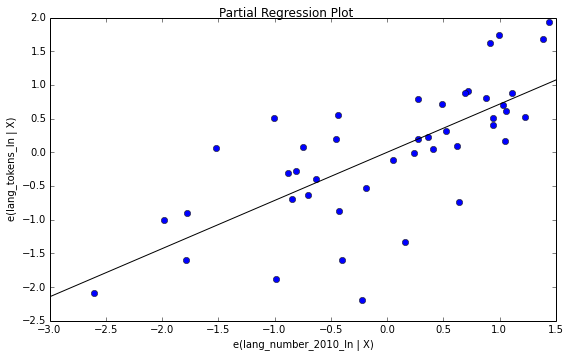

In [47]:
fig = plt.figure(figsize=(8,5))
fig = sm.graphics.plot_partregress_grid(results, fig=fig, exog_idx=[1])
plt.show()

In [48]:
results = ols('lang_tokens_ln ~ lang_number_2010_ln', numeric_inet_data_norm).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         lang_tokens_ln   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     43.80
Date:                Mon, 30 May 2016   Prob (F-statistic):           5.12e-08
Time:                        18:44:55   Log-Likelihood:                -46.212
No. Observations:                  44   AIC:                             96.42
Df Residuals:                      42   BIC:                             99.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept           -2.151e-16      0.107  -2.02e-15      1.000        -0.215     0.215
lang_number_2010_ln     0.7145      0.108      6.618      0.000         0.497     0.932
==============================================================================
Omnibus:                        5.138   Durbin-Watson:                   1.589
Prob(Omnibus):                  0.077   Jarque-Bera (JB):                3.893
Skew:                          -0.660   Prob(JB):                        0.143
Kurtosis:                       3.617   Cond. No.                         1.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

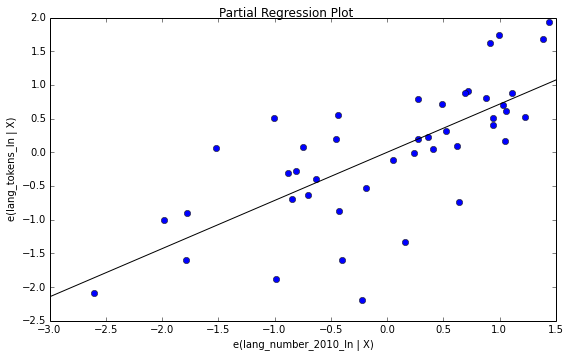

In [49]:
fig = plt.figure(figsize=(8,5))
fig = sm.graphics.plot_partregress_grid(results, fig=fig, exog_idx=[1])
plt.show()

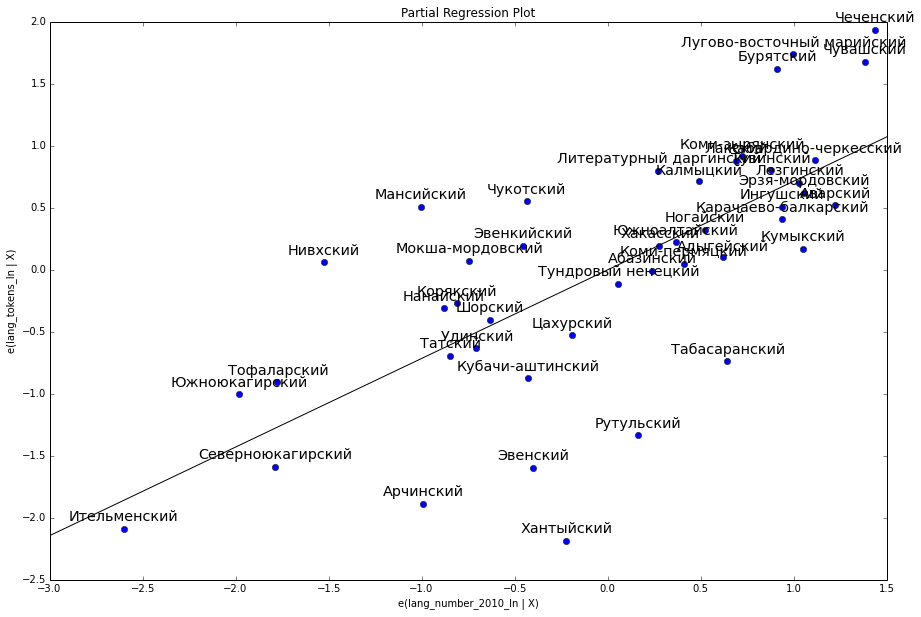

In [50]:
fix, ax = plt.subplots(figsize=(15,10))
fig = sm.graphics.plot_partregress("lang_tokens_ln", "lang_number_2010_ln", [""], data=numeric_inet_data_norm, ax=ax)

По данным этого небольшого регрессионного анализа видно, что количество токенов на языке зависит и от числа носителей 2002-го года и от числа носителей 2010-го года. Полученные значения и модель значимы, предсказательная способность (adj. r-squared) немного выше у регрессии для значения числа носителей за 2002-ой год, зато значимость выше у второй модели.

Попробуем с помощью множественной линейной регрессии проверить, какие факторы ещё могут влиять на представленность языка в интернете. Будем добавлять факторы группами, при этом из двух сильно коррелированных факторов "про одно и то же" (например, обращение книг, количество книг) будем выбирать какой-то один и за самый последний из известных годов.

In [51]:
# дополним данные категориальными признаками
numeric_inet_data_norm_with_cat = numeric_inet_data_norm.join(data_table_copy['iso_code'])
numeric_inet_data_norm_with_cat = numeric_inet_data_norm_with_cat.join(data_table_copy[categorical_cols])

numeric_data_norm_with_cat = numeric_data_norm.join(data_table_copy['iso_code'])
numeric_data_norm_with_cat = numeric_data_norm_with_cat.join(data_table_copy[categorical_cols])

In [52]:
# numeric_data_norm_with_cat.columns

In [53]:
# группы данных, С() means categorical
vk = ['lang_tokens_vk_ln', 'vk_communities_ln', 'vk_posts_ln', 'vk_posts_in_lang_ln']
wiki = ['lang_wiki_articles_2016_ln', 'lang_wiki_active_users_2016_ln', 'lang_wiki_admins_2016_ln', 'C(lang_wiki)']
papers = ['lang_number_books_2009_ln', 'lang_number_magazin_1996_ln', 'lang_number_newspapers_1996_ln']
people = ['lang_number_2010_ln',  'lang_detsad_ln', 
          #'lang_mean_age_ln', - в этом факторе слишком много na, регрессию нормальную не построить
          'region_citizens_percent', 'region_inet_user_percent_2011_ln',
          'region_birth_rate2014', 'region_death_rate2014_ln',
          'region_number_computers_per_family2010', 'region_population_growth2014',
         'region_density_of_population_ln']
budget = ['region_budget_cost2014', 'region_budget_emoluments2014', 
          'region_sr_dush_doxod2010', 'region_sr_mes_zp_2010', ] 
region_status = ['region_rating_position2014', 'region_rating_indx2014',
                 'C(region_FedDistrict)']
lang_status = ['C(lang_region)', 'iso_code', 'C(lang_status)', 'C(lang_family)']
other = ['C(lang_religion)'] # слишком много na, этот признак тут скорее для полноты картины)

Для примера посмотрим, что будет, если добавить все возможные признаки

In [54]:
ols_model = ols(formula='lang_tokens_ln ~ ' + ' + '.join(people + budget + region_status + papers + lang_status), data=numeric_inet_data_norm_with_cat).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         lang_tokens_ln   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                 -0.064
Method:                 Least Squares   F-statistic:                    0.9319
Date:                Mon, 30 May 2016   Prob (F-statistic):              0.620
Time:                        18:45:14   Log-Likelihood:                -7.0841
No. Observations:                  27   AIC:                             62.17
Df Residuals:                       3   BIC:                             93.27
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              -0.3520      0.502     -0.701      0.534        -1.951     1.247
C(region_FedDistrict)[T.ДВФО]                          -0.7552      0.989     -0.763      0.501        -3.903     2.393
C(region_FedDistrict)[T.ПФО]                           -1.1188      2.390     -0.468      0.672        -8.725     6.487
C(region_FedDistrict)[T.СЗФО]                           1.0352      1.594      0.649      0.562        -4.038     6.108
C(region_FedDistrict)[T.СКФО]                           0.6171      1.379      0.447      0.685        -3.773     5.007
C(region_FedDistrict)[T.СФО]                            0.3102      0.980      0.317      0.772        -2.808     3.428
C(region_FedDistrict)[T.УФО]                         3.146e-15   4.89e-15      0.643      0.566     -1.24e-14  1.87e-14
C(region_FedDistrict)[T.ЮФО]                           -0.4405      0.971     -0.454      0.681        -3.529     2.648
C(lang_region)[T.Алтай]                                -0.3013      0.869     -0.347      0.752        -3.068     2.466
C(lang_region)[T.Бурятия]                               1.3395      2.066      0.648      0.563        -5.235     7.915
C(lang_region)[T.Дагестан]                             -0.0723      0.442     -0.164      0.880        -1.478     1.334
C(lang_region)[T.Ингушетия]                          2.357e-15   3.99e-15      0.592      0.596     -1.03e-14   1.5e-14
C(lang_region)[T.Иркутская область]                 -1.756e-15    2.7e-15     -0.650      0.562     -1.04e-14  6.85e-15
C(lang_region)[T.Кабардино-Балкария]                -2.266e-15   4.04e-15     -0.561      0.614     -1.51e-14  1.06e-14
C(lang_region)[T.Калмыкия]                             -0.6342      1.312     -0.483      0.662        -4.809     3.541
C(lang_region)[T.Камчатский край]                   -7.321e-16   1.11e-15     -0.657      0.558     -4.28e-15  2.81e-15
C(lang_region)[T.Карачаево-Черкесия]                    0.6894      1.600      0.431      0.696        -4.402     5.781
C(lang_region)[T.Кемеровская область]                -8.14e-32   5.35e-31     -0.152      0.889     -1.78e-30  1.62e-30
C(lang_region)[T.Коми]                                  1.0352      1.594      0.649      0.562        -4.038     6.108
C(lang_region)[T.Магаданская область]                  -0.2611      0.312     -0.836      0.465        -1.255     0.733
C(lang_region)[T.Марий Эл]                              0.0588      1.096      0.054      0.961        -3.431     3.548
C(lang_region)[T.Мордовия]                             -0.6058      0.970     -0.624      0.577        -3.694     2.483
C(lang_region)[T.Пермский край]                      3.968e-17   4.61e-17      0.86

Видно, что модель хуже некуда. Adjusted R-squared отрицательный (произошло переобучение), модель не значима. При этом не видно ни одного значимого признака.
Будем добавлять признаки группами и пытаться выявить, из каких из них получится хорошая регрессионная модель.
Посмотрим сначала, влияют ли ещё какие-то факторы из группы, касающейся людей.

In [55]:
ols_model = ols(formula='lang_tokens_ln ~ ' + ' + '.join(people), data=numeric_inet_data_norm_with_cat).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         lang_tokens_ln   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     4.465
Date:                Mon, 30 May 2016   Prob (F-statistic):           0.000889
Time:                        18:45:42   Log-Likelihood:                -36.843
No. Observations:                  40   AIC:                             93.69
Df Residuals:                      30   BIC:                             110.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------------
Intercept                                 -0.0367      0.112     -0.328      0.745        -0.265     0.192
lang_number_2010_ln                        0.6996      0.193      3.622      0.001         0.305     1.094
lang_detsad_ln                             0.1469      0.156      0.944      0.353        -0.171     0.465
region_citizens_percent                    0.1263      0.310      0.407      0.687        -0.507     0.759
region_inet_user_percent_2011_ln          -0.0232      0.518     -0.045      0.965        -1.080     1.034
region_birth_rate2014                      0.4120      0.854      0.482      0.633        -1.333     2.157
region_death_rate2014_ln                  -0.2763      0.698     -0.396      0.695        -1.702     1.149
region_number_computers_per_family2010    -0.1283      0.330     -0.388      0.701        -0.803     0.546
region_population_growth2014              -0.7681      1.002     -0.767      0.449        -2.815     1.278
region_density_of_population_ln           -0.1471      0.231     -0.636      0.530        -0.619     0.325
==============================================================================
Omnibus:                        3.135   Durbin-Watson:                   1.502
Prob(Omnibus):                  0.209   Jarque-Bera (JB):                2.164
Skew:                          -0.241   Prob(JB):                        0.339
Kurtosis:                       4.032   Cond. No.                         25.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

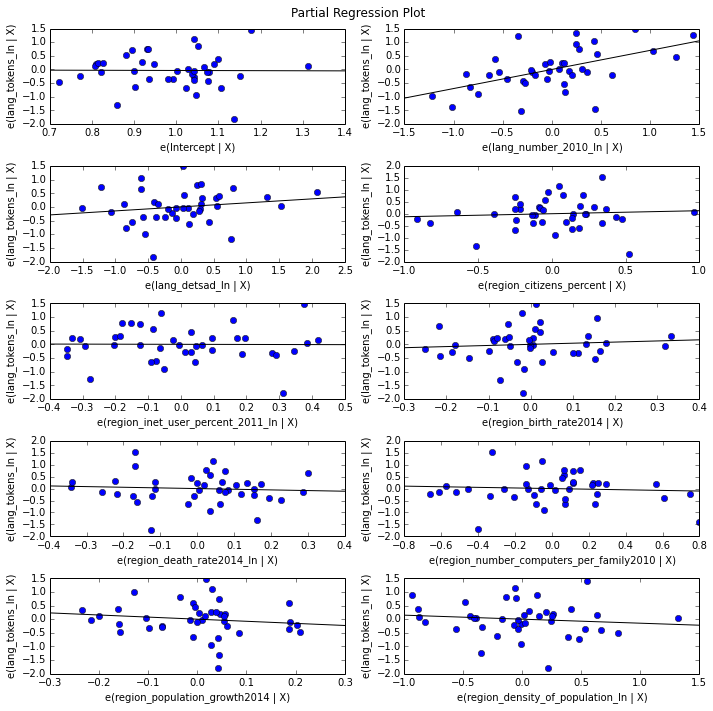

In [56]:
# In a partial regression plot, to discern the relationship between the response variable and the \(k\)-th variabe,
# we compute the residuals by regressing the response variable versus the independent variables excluding \(X_k\).
# We can denote this by \(X_{\sim k}\). We then compute the residuals by regressing \(X_k\) on \(X_{\sim k}\).
# The partial regression plot is the plot of the former versus the latter residuals. 
fig = plt.figure(figsize=(10,10))
fig = sm.graphics.plot_partregress_grid(ols_model, fig=fig)
plt.show()

Эта модель хуже самой первой, в которой учитывается только число носителей за 2010 год: меньше adj. r-squared, f-statistics и её значимость, а ни одного значимого коэффициента не прибавилось. Посмотрим на другие группы.

Можно предположить, что наши интернет-данные связаны как-нибудь с благополучием региона, хотя по регистрациям сайтов мы видели, что сайты необязательно созданы/зарегистрированы/хостятся в титульном регионе распространения. Проверим это предположение.

In [57]:
ols_model = ols(formula='lang_tokens_ln ~ ' + ' + '.join(budget), data=numeric_inet_data_norm_with_cat).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         lang_tokens_ln   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     2.840
Date:                Mon, 30 May 2016   Prob (F-statistic):             0.0369
Time:                        18:45:56   Log-Likelihood:                -56.304
No. Observations:                  44   AIC:                             122.6
Df Residuals:                      39   BIC:                             131.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept                    -2.151e-16      0.139  -1.54e-15      1.000        -0.282     0.282
region_budget_cost2014          -0.6241      1.708     -0.365      0.717        -4.079     2.830
region_budget_emoluments2014     0.2096      1.724      0.122      0.904        -3.277     3.696
region_sr_dush_doxod2010         0.0238      0.359      0.066      0.947        -0.701     0.749
region_sr_mes_zp_2010           -0.1398      0.343     -0.407      0.686        -0.835     0.555
==============================================================================
Omnibus:                        0.130   Durbin-Watson:                   1.548
Prob(Omnibus):                  0.937   Jarque-Bera (JB):                0.036
Skew:                          -0.057   Prob(JB):                        0.982
Kurtosis:                       2.921   Cond. No.                         29.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Ни один из коэффициентов не значим. Посмотрим на остальные группы.

In [58]:
# место занимают
# fig = plt.figure(figsize=(15,20))
# fig = sm.graphics.plot_partregress_grid(glm_model, fig=fig)
# plt.show()

In [59]:
ols_model = ols(formula='lang_tokens_ln ~ ' + ' + '.join(papers), data=numeric_inet_data_norm_with_cat).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         lang_tokens_ln   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     10.97
Date:                Mon, 30 May 2016   Prob (F-statistic):           2.16e-05
Time:                        18:46:01   Log-Likelihood:                -48.718
No. Observations:                  44   AIC:                             105.4
Df Residuals:                      40   BIC:                             112.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Intercept                      -2.151e-16      0.116  -1.86e-15      1.000        -0.234     0.234
lang_number_books_2009_ln          0.3753      0.135      2.789      0.008         0.103     0.647
lang_number_magazin_1996_ln        0.1902      0.178      1.067      0.292        -0.170     0.551
lang_number_newspapers_1996_ln     0.2489      0.192      1.296      0.202        -0.139     0.637
==============================================================================
Omnibus:                        0.900   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.638   Jarque-Bera (JB):                0.748
Skew:                          -0.310   Prob(JB):                        0.688
Kurtosis:                       2.842   Cond. No.                         3.03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
ols_model = ols(formula='lang_tokens_ln ~ ' + ' + '.join(region_status), data=numeric_inet_data_norm_with_cat).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         lang_tokens_ln   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     1.711
Date:                Mon, 30 May 2016   Prob (F-statistic):              0.125
Time:                        18:46:04   Log-Likelihood:                -53.710
No. Observations:                  44   AIC:                             127.4
Df Residuals:                      34   BIC:                             145.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Intercept                        -1.4383      4.408     -0.326      0.746       -10.396     7.520
C(region_FedDistrict)[T.ДВФО]     0.8009      4.519      0.177      0.860        -8.384     9.986
C(region_FedDistrict)[T.ПФО]      2.6021      4.465      0.583      0.564        -6.472    11.677
C(region_FedDistrict)[T.СЗФО]     2.5684      4.640      0.554      0.584        -6.861    11.998
C(region_FedDistrict)[T.СКФО]     1.3170      4.597      0.286      0.776        -8.026    10.660
C(region_FedDistrict)[T.СФО]      1.5357      4.521      0.340      0.736        -7.652    10.723
C(region_FedDistrict)[T.УФО]      1.5472      4.376      0.354      0.726        -7.346    10.440
C(region_FedDistrict)[T.ЮФО]      1.6847      4.349      0.387      0.701        -7.154    10.523
region_rating_position2014        0.0569      0.603      0.094      0.925        -1.169     1.283
region_rating_indx2014           -0.4192      0.633     -0.662      0.512        -1.705     0.867
==============================================================================
Omnibus:                        0.661   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.718   Jarque-Bera (JB):                0.761
Skew:                          -0.175   Prob(JB):                        0.684
Kurtosis:                       2.459   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
ols_model = ols(formula='lang_tokens_ln ~ ' + ' + '.join(lang_status), data=numeric_inet_data_norm_with_cat).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         lang_tokens_ln   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     1.604
Date:                Mon, 30 May 2016   Prob (F-statistic):              0.251
Time:                        18:46:07   Log-Likelihood:                -15.454
No. Observations:                  29   AIC:                             72.91
Df Residuals:                       8   BIC:                             101.6
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                               0.0501      0.392      0.128      0.902        -0.855     0.955
C(lang_region)[T.Алтай]                                -0.2911      1.570     -0.185      0.858        -3.911     3.329
C(lang_region)[T.Бурятия]                               0.8100      0.641      1.264      0.242        -0.668     2.288
C(lang_region)[T.Дагестан]                             -0.2698      1.469     -0.184      0.859        -3.656     3.117
C(lang_region)[T.Ингушетия]                             0.1952      1.691      0.115      0.911        -3.705     4.096
C(lang_region)[T.Иркутская область]                   8.73e-16   8.53e-16      1.024      0.336     -1.09e-15  2.84e-15
C(lang_region)[T.Кабардино-Балкария]                -2.629e-16   1.74e-15     -0.151      0.884     -4.28e-15  3.75e-15
C(lang_region)[T.Калмыкия]                             -0.0978      0.641     -0.153      0.882        -1.576     1.380
C(lang_region)[T.Камчатский край]                     2.31e-16   4.62e-16      0.500      0.630     -8.34e-16   1.3e-15
C(lang_region)[T.Карачаево-Черкесия]                   -0.1065      1.110     -0.096      0.926        -2.666     2.453
C(lang_region)[T.Кемеровская область]               -3.059e-16   3.31e-16     -0.924      0.382     -1.07e-15  4.57e-16
C(lang_region)[T.Коми]                                  0.1413      0.665      0.212      0.837        -1.393     1.676
C(lang_region)[T.Магаданская область]                  -0.1712      0.678     -0.253      0.807        -1.734     1.391
C(lang_region)[T.Марий Эл]                              0.9621      0.665      1.446      0.186        -0.573     2.497
C(lang_region)[T.Мордовия]                             -0.4290      0.537     -0.798      0.448        -1.668     0.810
C(lang_region)[T.Пермский край]                      1.201e-16   1.61e-16      0.744      0.478     -2.52e-16  4.92e-16
C(lang_region)[T.Ростовская область]                 1.151e-17   2.85e-17      0.405      0.696     -5.41e-17  7.71e-17
C(lang_region)[T.Тыва]                                  0.2898      1.570      0.185      0.858        -3.331     3.910
C(lang_region)[T.Хабаровский край]                  -1.898e-17   1.13e-16     -0.168      0.871      -2.8e-16  2.42e-16
C(lang_region)[T.Хакасия]                              -0.3222      1.570     -0.205      0.843        -3.942     3.298
C(lang_region)[T.Ханты-Мансийский автономный округ] -1.986e-17    1.2e-16     -0.166      0.872     -2.96e-16  2.56e-16
C(lang_region)[T.Чечня]                                 1.6208      1.691      0.958      0.366        -2.280     5.521
C(lang_region)[T.Чувашия]                               1.1645      1.570      0.74

Последние две модели не значимы, а вот первая (зависимость от печатной продукции) любопытна. Количество книг за (на?) 2009 год неплохо предсказывает количество токенов на языке, которые мы можем ожидать найти в интернете на малом языке.

Дальше я не буду приводить полные модели, но я опробовала следующие комбинации:
* lang_number_2010_ln + ' + ' + '.join(lang_status) - плохо, модель не значима
* lang_number_2010_ln + C(iso_code) - спорно. модель значима, adj.r-squared больше, чем просто от числа носителей (0.495), но значимость f-статистики немного больше (что повышает вероятность модели ошибаться). Сам параметр iso_code не значим
* C(iso_code), C(lang_region) - модель не значима
* lang_number_2010_ln + ' + ' + '.join(region_status) - не так плохо, но хуже, чем с iso_code или вообще без этих признаков
* C(FedDisctrict) - модель не значима, из region_rating_indx2014 и region_rating_position2014 в сочетании с числом носителей лучше работает второй, но сама модель не лучше той, что с iso_code (adj.r-squared 0.491; Prob (F-statistic): 	3.69e-07
* дальше в https://github.com/irinfox/minor_langs_internet_analysis/blob/master/data/params_for_ols.tsv

In [67]:
ols_model = ols(formula='lang_tokens_ln ~ lang_number_2010_ln + region_population_growth2014 + region_budget_cost2014 + lang_number_newspapers_1996_ln', data=numeric_inet_data_norm_with_cat).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         lang_tokens_ln   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     16.52
Date:                Mon, 30 May 2016   Prob (F-statistic):           5.36e-08
Time:                        18:49:23   Log-Likelihood:                -40.123
No. Observations:                  44   AIC:                             90.25
Df Residuals:                      39   BIC:                             99.17
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Intercept                      -2.151e-16      0.096  -2.23e-15      1.000        -0.195     0.195
lang_number_2010_ln                0.5634      0.136      4.151      0.000         0.289     0.838
region_population_growth2014      -0.1654      0.110     -1.510      0.139        -0.387     0.056
region_budget_cost2014            -0.1859      0.111     -1.671      0.103        -0.411     0.039
lang_number_newspapers_1996_ln     0.2368      0.119      1.987      0.054        -0.004     0.478
==============================================================================
Omnibus:                        1.730   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.421   Jarque-Bera (JB):                0.848
Skew:                           0.127   Prob(JB):                        0.654
Kurtosis:                       3.631   Cond. No.                         2.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Кажется, это лучшая модель, объясняющая онлайн-данные из Интернета на основе оффлайн-данных. Она показывает высокие значения adjusted r-squared (0.591-0.632) и является значимой для всех вычисленных нами интернет-параметрах (количество токенов, веб-страниц, сайтов, сайтов на малых языках).
Посмотрим на распределение остатков.

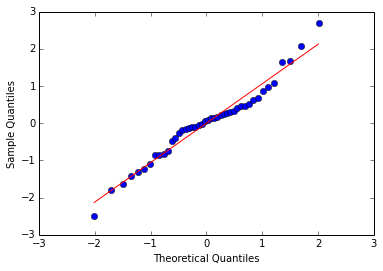

In [69]:
resid = ols_model.resid
graphics.gofplots.qqplot(resid, line='r', fit=True)
plt.show()

Кажется, в данных видны три аутлаера, в остальном модель хорошо подходит под данные.
Попробуем предсказать один из интернет-параметров, предварительно убрав данные о нём и переобучив модель.

In [70]:
# линейная модель лучше работает для языков, параметры которых лежат в диапазоне имеющихся значений параметров
exclude_index = ['Кубачи-аштинский'] 

no_predict_lang = numeric_inet_data_after_ln[-numeric_inet_data_after_ln.index.isin(exclude_index)]
inet_mean = no_predict_lang.mean()
inet_std = no_predict_lang.std()
test_inet_data_norm = (no_predict_lang - inet_mean) / (inet_std)

# в столбцах, где было много nan изначально, нормировка даёт полный столбец nan, выкинем их
test_inet_data_norm = test_inet_data_norm.dropna(axis=1, how='all')
test_inet_data_norm_with_cat = test_inet_data_norm.join(data_table_copy['iso_code'])
test_inet_data_norm_with_cat = test_inet_data_norm_with_cat.join(data_table_copy[categorical_cols])

ols_model = ols(formula='lang_tokens_ln ~ lang_number_2010_ln + region_population_growth2014 + region_budget_cost2014 + lang_number_newspapers_1996_ln', data=test_inet_data_norm_with_cat).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         lang_tokens_ln   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     15.76
Date:                Mon, 30 May 2016   Prob (F-statistic):           1.09e-07
Time:                        18:50:36   Log-Likelihood:                -39.480
No. Observations:                  43   AIC:                             88.96
Df Residuals:                      38   BIC:                             97.77
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Intercept                      -3.331e-16      0.098  -3.39e-15      1.000        -0.199     0.199
lang_number_2010_ln                0.5619      0.139      4.053      0.000         0.281     0.842
region_population_growth2014      -0.1552      0.112     -1.382      0.175        -0.383     0.072
region_budget_cost2014            -0.1909      0.114     -1.679      0.101        -0.421     0.039
lang_number_newspapers_1996_ln     0.2350      0.121      1.942      0.060        -0.010     0.480
==============================================================================
Omnibus:                        1.480   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.477   Jarque-Bera (JB):                0.634
Skew:                           0.082   Prob(JB):                        0.728
Kurtosis:                       3.572   Cond. No.                         2.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
predict_lang = numeric_inet_data_after_ln[numeric_inet_data_after_ln.index.isin(exclude_index)]
predict_lang_norm = (predict_lang - inet_mean) / (inet_std)
predict_with_const = sm.add_constant(predict_lang_norm)
predicted = ols_model.predict(predict_with_const)
print(predicted)
real_val = numeric_data_corp[numeric_data_corp.index.isin(exclude_index)]
print(real_val['lang_tokens'])
print(np.exp(predicted * inet_std['lang_tokens_ln'] + inet_mean['lang_tokens_ln']))

[-0.59161845]
lang_ru
Кубачи-аштинский    10303
Name: lang_tokens, dtype: int64
[ 29393.74460417]


Предсказательная способность этой модели не очень хороша. Были опробованы три разных языка, везде предсказанные и реальные значения отличаются минимум в два раза.
Для эрзя-мордовского модель предсказала 10млн токенов, а на самом деле их всего 2млн.

Посмотрим, можно ли найти линейную зависимость между нашими интернет-данными и другими онлайн-данными (по вконтакте или википедии).

In [72]:
ols_model = ols(formula='lang_tokens_ln ~ ' + ' + '.join(wiki + vk), data=numeric_data_norm_with_cat).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         lang_tokens_ln   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     8.124
Date:                Mon, 30 May 2016   Prob (F-statistic):           4.48e-06
Time:                        18:52:54   Log-Likelihood:                -32.834
No. Observations:                  41   AIC:                             85.67
Df Residuals:                      31   BIC:                             102.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Intercept                          0.5181      0.451      1.148      0.260        -0.402     1.439
C(lang_wiki)[T.none]              -0.0800      0.431     -0.186      0.854        -0.958     0.798
C(lang_wiki)[T.wiki]              -1.3949      1.190     -1.172      0.250        -3.822     1.032
lang_wiki_articles_2016_ln         0.7570      0.283      2.680      0.012         0.181     1.333
lang_wiki_active_users_2016_ln     0.6770      0.686      0.987      0.331        -0.722     2.076
lang_wiki_admins_2016_ln          -0.1215      0.159     -0.766      0.449        -0.445     0.202
lang_tokens_vk_ln                 -0.1258      0.714     -0.176      0.861        -1.581     1.330
vk_communities_ln                  0.1785      0.295      0.606      0.549        -0.422     0.779
vk_posts_ln                        0.6024      0.916      0.658      0.516        -1.266     2.470
vk_posts_in_lang_ln               -0.4887      0.814     -0.600      0.553        -2.150     1.172
==============================================================================
Omnibus:                        2.914   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.233   Jarque-Bera (JB):                1.838
Skew:                          -0.303   Prob(JB):                        0.399
Kurtosis:                       3.842   Cond. No.                         34.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Модель значима, описывает те же 60% данных. Единственный значимый параметр - количество статей за 2016-ый год. Попробуем выбросить наиболее незначимые, а затем построить совместную модель онлайн и оффлайн данных.

In [74]:
# кажется, лучшая для онлайн
ols_model = ols(formula='lang_tokens_ln ~ lang_wiki_articles_2016_ln + lang_tokens_vk_ln', data=numeric_data_norm_with_cat).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         lang_tokens_ln   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     39.47
Date:                Mon, 30 May 2016   Prob (F-statistic):           5.31e-10
Time:                        18:53:05   Log-Likelihood:                -34.628
No. Observations:                  41   AIC:                             75.26
Df Residuals:                      38   BIC:                             80.40
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                   -7.98e-17      0.091  -8.74e-16      1.000        -0.185     0.185
lang_wiki_articles_2016_ln     0.7247      0.127      5.702      0.000         0.467     0.982
lang_tokens_vk_ln              0.1329      0.127      1.045      0.302        -0.124     0.390
==============================================================================
Omnibus:                        1.137   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.566   Jarque-Bera (JB):                0.424
Skew:                          -0.182   Prob(JB):                        0.809
Kurtosis:                       3.341   Cond. No.                         2.32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
# объединим признаки из лучших моделей по онлайн и оффлайн данным
ols_model = ols(formula='lang_tokens_ln ~ lang_wiki_articles_2016_ln + lang_tokens_vk_ln + lang_number_2010_ln + region_population_growth2014 + region_budget_cost2014 + lang_number_newspapers_1996_ln', data=numeric_data_norm_with_cat).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         lang_tokens_ln   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     13.97
Date:                Mon, 30 May 2016   Prob (F-statistic):           6.03e-08
Time:                        18:57:02   Log-Likelihood:                -32.191
No. Observations:                  41   AIC:                             78.38
Df Residuals:                      34   BIC:                             90.38
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Intercept                       -7.98e-17      0.091  -8.77e-16      1.000        -0.185     0.185
lang_wiki_articles_2016_ln         0.5116      0.164      3.124      0.004         0.179     0.844
lang_tokens_vk_ln                 -0.0465      0.167     -0.278      0.783        -0.386     0.293
lang_number_2010_ln                0.2815      0.186      1.511      0.140        -0.097     0.660
region_population_growth2014      -0.0806      0.110     -0.731      0.470        -0.305     0.143
region_budget_cost2014            -0.1022      0.121     -0.847      0.403        -0.348     0.143
lang_number_newspapers_1996_ln     0.1214      0.122      0.995      0.327        -0.127     0.370
==============================================================================
Omnibus:                        2.375   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.305   Jarque-Bera (JB):                1.434
Skew:                           0.126   Prob(JB):                        0.488
Kurtosis:                       3.881   Cond. No.                         4.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

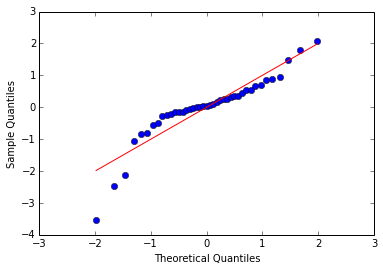

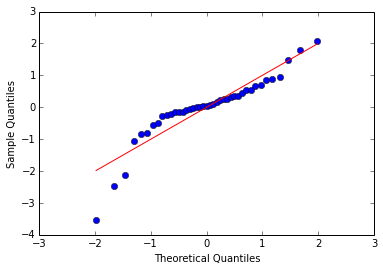

In [213]:
# ols
resid = ols_model.resid
graphics.gofplots.qqplot(resid, line='r', fit=True)

In [390]:
# линейная модель лучше работает для языков, параметры которых лежат в диапазоне имеющихся значений параметров
exclude_index = ['Калмыцкий'] 

no_predict_lang = numeric_data_after_ln[-numeric_data_after_ln.index.isin(exclude_index)]
mean = no_predict_lang.mean()
std = no_predict_lang.std()
test_data_norm = (no_predict_lang - mean) / (std)

# в столбцах, где было много nan изначально, нормировка даёт полный столбец nan, выкинем их
test_data_norm = test_data_norm.dropna(axis=1, how='all')
test_data_norm_with_cat = test_data_norm.join(data_table_copy['iso_code'])
test_data_norm_with_cat = test_data_norm_with_cat.join(data_table_copy[categorical_cols])

ols_model = ols(formula='type1_domains_found_ln ~ lang_wiki_articles_2016_ln + lang_tokens_vk_ln + lang_number_2010_ln + region_population_growth2014 + region_budget_cost2014 + lang_number_newspapers_1996_ln', data=test_data_norm_with_cat).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     type1_domains_found_ln   R-squared:                       0.789
Model:                                OLS   Adj. R-squared:                  0.750
Method:                     Least Squares   F-statistic:                     20.55
Date:                    Fri, 27 May 2016   Prob (F-statistic):           7.43e-10
Time:                            17:34:15   Log-Likelihood:                -25.145
No. Observations:                      40   AIC:                             64.29
Df Residuals:                          33   BIC:                             76.11
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Intercept                       1.318e-16      0.079   1.67e-15      1.000        -0.161     0.161
lang_wiki_articles_2016_ln         0.4231      0.141      2.998      0.005         0.136     0.710
lang_tokens_vk_ln                  0.2258      0.144      1.572      0.125        -0.066     0.518
lang_number_2010_ln                0.0284      0.161      0.176      0.861        -0.299     0.356
region_population_growth2014       0.1001      0.096      1.048      0.302        -0.094     0.295
region_budget_cost2014            -0.0375      0.103     -0.363      0.719        -0.248     0.173
lang_number_newspapers_1996_ln     0.3318      0.106      3.124      0.004         0.116     0.548
==============================================================================
Omnibus:                       16.905   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.013
Skew:                          -1.177   Prob(JB):                     3.70e-06
Kurtosis:                       6.076   Cond. No.                         4.58
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [215]:
predict_lang = numeric_data_after_ln[numeric_data_after_ln.index.isin(exclude_index)]
predict_lang_norm = (predict_lang - mean) / (std)
predict_with_const = sm.add_constant(predict_lang_norm)
predicted = ols_model.predict(predict_with_const)
print(predicted)
real_val = numeric_data_corp[numeric_data_corp.index.isin(exclude_index)]
print(real_val['type1_domains_found'])
print(np.exp(predicted * inet_std['type1_domains_found_ln'] + inet_mean['type1_domains_found_ln']))

[ 0.71488]
lang_ru
Калмыцкий    5
Name: type1_domains_found, dtype: int64
[ 5.03342]


Можно сказать, что эта модель довольно сносно предсказывает.
* Для кубачи-аштинского - 0.8 вместо 0 (т.е. по сути 1)
* Для лезгинского 6.82 вместо 5
* Для эрзя-мордовского хуже - 4.9 вместо 7.
* Для чеченского 11 вместо 25.
* Для калмыцкого прямое попадание - 5.

# Иерархическая кластеризация

In [220]:
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

Для иерархической кластеризации важно выбрать тип расчёта расстояния между объектами. Их существует 5: расстояние ближнего соседа, расстояние дальнего соседа, групповое среднее расстояние, расстояние между центрами, расстояние Уорда. 

Дефолтным методом обычно берут расстояние Уорда.
Его же советует в своей презентации Воронцов (лектор ШАДа по маш. обучению).
http://www.machinelearning.ru/wiki/images/2/28/Voron-ML-Clustering-slides.pdf (см. стр. 40; наглядные иллюстрации разных расстояний - стр. 29-34).
Я тоже воспользуюсь методом Уорда.

"В методе Уорда в качестве расстояния между кластерами берётся прирост суммы квадратов расстояний объектов до центров кластеров, получаемый в результате их объединения[6]. В отличие от других методов кластерного анализа, для оценки расстояний между кластерами здесь используются методы дисперсионного анализа. На каждом шаге алгоритма объединяются такие два кластера, которые приводят к минимальному увеличению целевой функции, то есть внутригрупповой суммы квадратов. Этот метод направлен на объединение близко расположенных кластеров."
(https://ru.wikipedia.org/wiki/%D0%98%D0%B5%D1%80%D0%B0%D1%80%D1%85%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F)

In [221]:
numeric_data_norm.shape

(41, 51)

In [222]:
numeric_data_norm_no_na = numeric_data_norm.dropna(how="any", axis=1)
inet_cols = ['all_domains_ln', 'lang_tokens_ln', 'token_median_ln',
             'type1_domains_crawled_ln', 'type1_domains_found_ln', 'type1_to_all_ln', 'urls_ln']
numeric_data_norm_no_na.shape

(41, 44)

In [223]:
numeric_data_norm_no_na = numeric_data_norm.dropna(how="any", axis=1)
Z = linkage(numeric_data_norm_no_na, 'ward')
c, coph_dists = cophenet(Z, pdist(numeric_data_norm_no_na))
c

0.59644492952475225

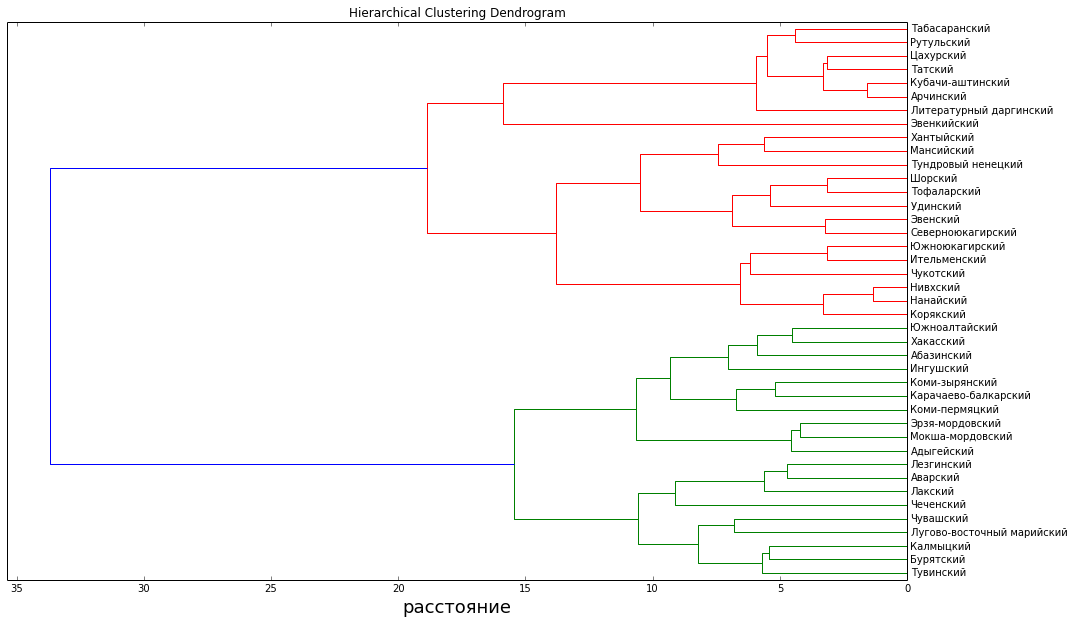

In [232]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('расстояние', fontsize=18)
plt.subplots_adjust(left=0.40)
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=18.,  # font size for the x axis labels
    labels=numeric_data_norm_no_na.index,
    orientation='right',
)
plt.savefig('hierarchical_all_not_none_data.png', dpi=100)

0.698589895693


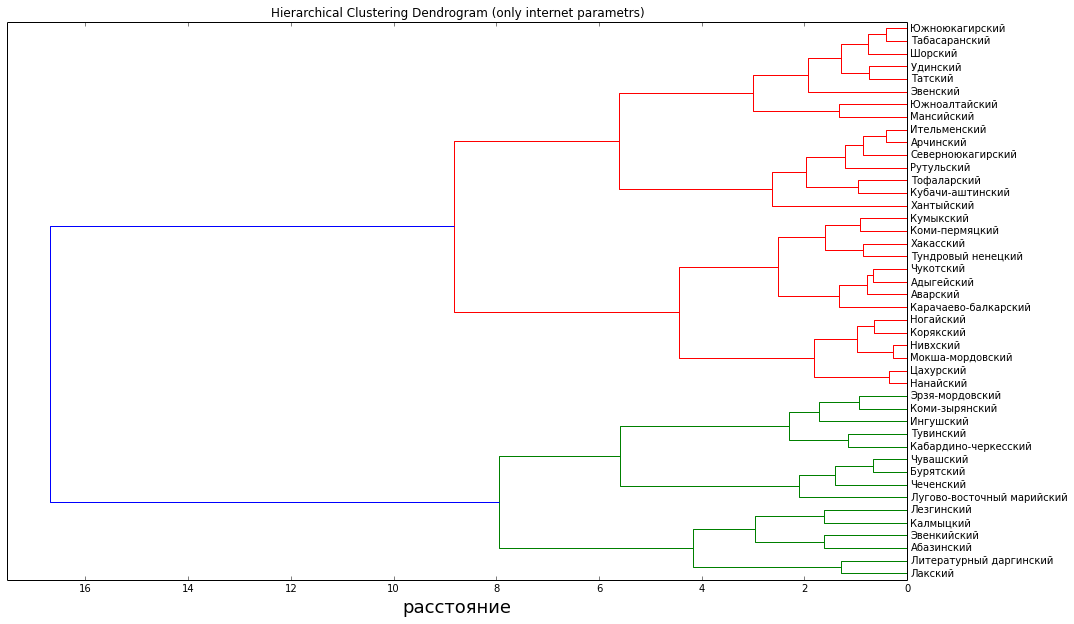

In [233]:
numeric_inet_data_norm_no_na = numeric_inet_data_norm.dropna(how="any", axis=1)
numeric_inet_data_norm_no_na = numeric_inet_data_norm_no_na.ix[:, inet_cols]


Z = linkage(numeric_inet_data_norm_no_na, 'ward')

c, coph_dists = cophenet(Z, pdist(numeric_inet_data_norm_no_na))
print(c)

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram (only internet parametrs)')
plt.xlabel('расстояние', fontsize=18)
plt.subplots_adjust(left=0.40)
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=18.,  # font size for the x axis labels
    labels=numeric_inet_data_norm_no_na.index,
    orientation='right',
)
# plt.show()
plt.savefig('hierarchical_only_inet.png', dpi=100)

In [387]:
vk_upd = ['lang_tokens_vk_ln', 'vk_communities_ln', 'vk_posts_in_lang_ln']
budget_upd = ['region_budget_cost2014', # 'region_budget_cost2010', region_budget_cost2011',
              'region_budget_emoluments2014', # 'region_budget_emoluments2010','region_budget_emoluments2011',
              'region_sr_dush_doxod2010',
              'region_sr_mes_zp_2015_ln'] #, 'region_sr_mes_zp_2010']
papers_upd = ['lang_circulation_books_2009_ln',
              'lang_number_books_2009_ln',
              'lang_circulation_magazin_1996_ln',
              'lang_number_magazin_1996_ln',
              'lang_circulation_newspaper_1996_ln',
              'lang_number_newspapers_1996_ln']
region_rating = ['region_rating_indx2014', 'region_rating_position2014']
people_upd = [#'lang_number_2010_ln', 'lang_number_2002_ln', #'lang_detsad_ln', 'lang_mean_age_ln',
              #'region_death_rate2014_ln', #'region_birth_rate2014',
              #'region_density_of_population_ln',
              'region_inet_user_percent_2011_ln'#, 'region_inet_user_percent_2010_ln',
              #'lang_augmentation_2002_2010_percent',
             #'region_number_computers_per_family2010', # 'region_citizens_percent',
             'region_population_growth2014']
#numeric_data_norm.columns
wiki_upd = ['lang_wiki_articles_2016_ln', 'lang_wiki_active_users_2016_ln'] #, 'lang_wiki_admins_2016_ln']

0.70274284818


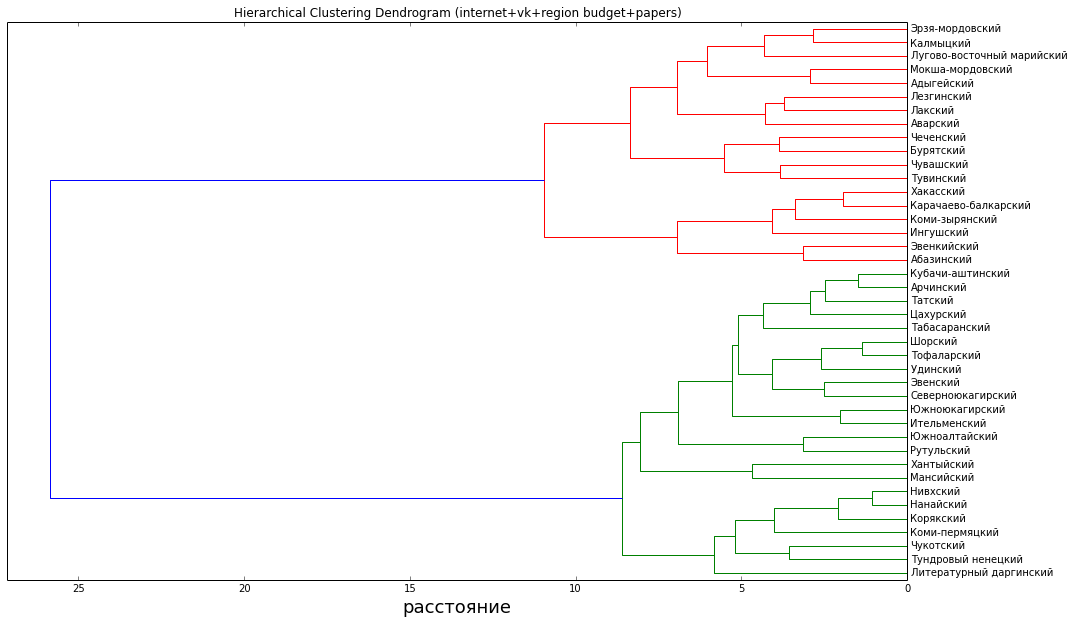

In [388]:
numeric_data_norm_no_na = numeric_data_norm.ix[:, inet_cols + vk_upd + budget_upd + papers_upd]
numeric_data_norm_no_na = numeric_data_norm_no_na.dropna(how="any", axis=1)


Z = linkage(numeric_data_norm_no_na, 'ward')
c, coph_dists = cophenet(Z, pdist(numeric_data_norm_no_na))
print(c) # коэффициент показывает, насколько хорошо модель подходит данным

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram (internet+vk+region budget+papers)')
plt.xlabel('расстояние', fontsize=18)
plt.subplots_adjust(left=0.40)
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=18.,  # font size for the x axis labels
    labels=numeric_data_norm_no_na.index,
    orientation='right',
)
# plt.show()
plt.savefig('hierarchical_best_online_and_offline.png', dpi=100)